In [8]:
# Cell 1: Install Kaggle library and upload your Kaggle API token
!pip install kaggle -q

from google.colab import files

print("Please upload the kaggle.json file you downloaded from your Kaggle account")
files.upload()

# Create a directory for the Kaggle API credentials and move the file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully!")

Please upload the kaggle.json file you downloaded from your Kaggle account


Saving kaggle.json to kaggle.json

Kaggle API configured successfully!


In [10]:
# Cell 2: Download the dataset from Kaggle
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 407MB/s]


In [11]:
# Cell 3: Unzip the downloaded files
# The '-q' flag makes the output quiet
!unzip -q house-prices-advanced-regression-techniques.zip -d .

print("Files unzipped successfully.")

Files unzipped successfully.


In [12]:
# Cell 4: Load Libraries and Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Set some display options for pandas
pd.set_option('display.max_columns', None)

# Load the training and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Store the 'Id' columns to use for the submission file later
train_ID = train_df['Id']
test_ID = test_df['Id']

# Drop the 'Id' column as it's not a predictive feature
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (1460, 80)
Test data shape: (1459, 79)


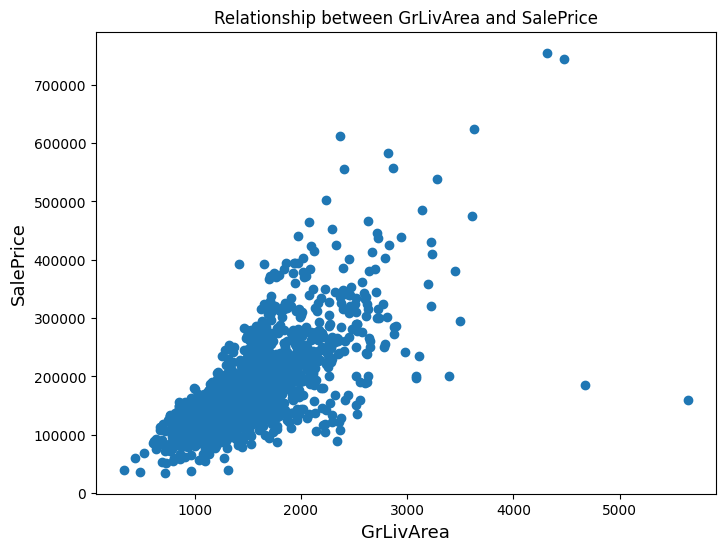

Data shape after removing outliers: (1458, 80)


In [13]:
# Cell 5: Visualize and Handle Outliers in 'GrLivArea'
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title("Relationship between GrLivArea and SalePrice")
plt.show()

# Based on the plot, we see two outliers with large GrLivArea but low SalePrice
# Let's remove them
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

print(f"Data shape after removing outliers: {train_df.shape}")

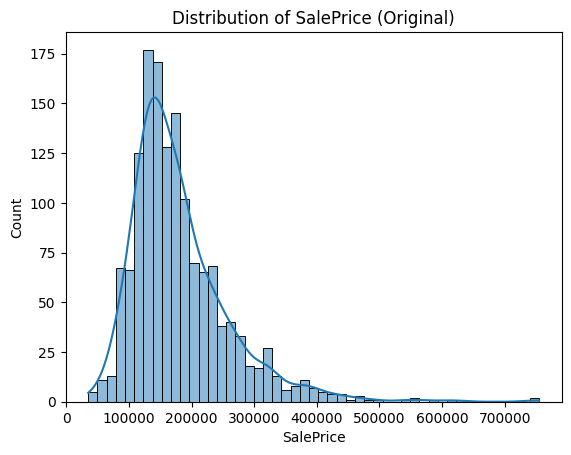

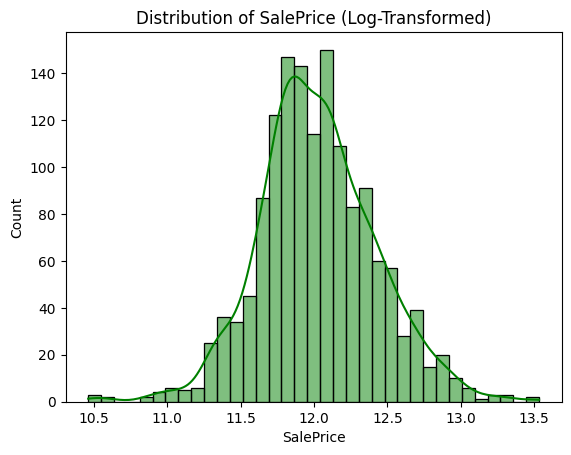

In [14]:
# Cell 6: Log-Transform the Target Variable ('SalePrice')
# The target variable is right-skewed. A log transformation can make it more normal.
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice (Original)')
plt.show()

train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

sns.histplot(train_df['SalePrice'], kde=True, color='green')
plt.title('Distribution of SalePrice (Log-Transformed)')
plt.show()

In [15]:
# Cell 7: Concatenate Data for Preprocessing
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df.SalePrice.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("Combined data shape:", all_data.shape)

Combined data shape: (2917, 79)


In [16]:
# Cell 8: Impute Missing Values
# For many features, 'NA' means 'None' (e.g., no pool, no alley access)

# Features where NA means 'None'
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

# Features where NA likely means 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

# For 'LotFrontage', fill missing values with the median of the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# For categorical features, fill with the mode (most common value)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# 'Functional': NA means 'Typical'
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Drop the 'Utilities' feature as it has almost no variance
all_data = all_data.drop(['Utilities'], axis=1)

# Check if any missing values remain
print("Remaining missing values:", all_data.isnull().sum().max())

Remaining missing values: 0


In [17]:
# Cell 9: Transform Numerical Features that are Actually Categorical
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [18]:
# Cell 10: Create New Combined Features
# Combine existing features to create more meaningful ones.

# Total square footage of the house
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Total number of bathrooms
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Total porch area
all_data['Total_Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                             all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                             all_data['WoodDeckSF'])

# Simplified quality indicators
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [19]:
# Cell 11: Handle Skewed Numerical Features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Compute skewness
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index

# Apply log transformation to these skewed features
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

print(f"{len(skewed_feats)} numerical features were log-transformed.")

25 numerical features were log-transformed.


In [20]:
# Cell 12: Convert Categorical Features to Dummy Variables (One-Hot Encoding)
all_data = pd.get_dummies(all_data)
print("Shape of data after one-hot encoding:", all_data.shape)

Shape of data after one-hot encoding: (2917, 345)


In [22]:
# Cell 13: Split Data Back into Train and Test Sets
train = all_data[:ntrain]
test = all_data[ntrain:]

# The 'y_train' variable was already created. Assign our final dataframes.
X_train = train
X_test = test

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)


Training data shape: (1458, 345)
Test data shape: (1459, 345)
Training labels shape: (1458,)
